# <font color="#EA1D2C">Projeto - Análise Exploratória dos Dados (Ada Tech - Ifood)</font>
<hr color="#F5F5F5" size="1">

**Por: [Isadora Mesquita](https://www.linkedin.com/in/isadora-mesquita-895b77190/), [Ingrid Barbosa](https://www.linkedin.com/in/ingridf-abarbosa) e [Eliane Santos](https://www.linkedin.com/in/eliane-analistadedados?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=ios_app)**

<a id='Objetivos fornecidos pelo orientador em documento:'></a>
# <font color="#FFDEBB">Objetivos</font>
<hr color="#F5F5F5" size="1">

A partir de um conjunto de dados (escolhido por vocês ou por sugestão do professor), o objetivo será desenvolver uma análise exploratória dos dados. Para isto segue alguns dos pontos cruciais para o desenvolvimento do projeto:

<br>

- __Definição do Conjunto de Dados:__ Determinar qual conjunto de dados deve ser analisado e se o conjunto de dados atende as espectativas para o projeto;

<br>

- __Análise de Consistência dos Dados__: Verificar se o conjunto de dados tem algum eventual problema (podendo ser dados faltantes, dados erroneos entre outros casos);

<br>

- __Análise Exploratória dos Dados__: Consiste em estudar o conjunto de dados! Então seria entender quais tipos de informações que pode-se obter, quais conclusões e/ou interpretações pode-se tirar dos dados (neste caso, gráfico para auxiliar nas análises são bem vindos).

<br>

__Observações.:__ Este projeto pode ser feito individualmente ou em grupos de no máximo 3 pessoas;

__Data de Entrega:__ 15/03/2024

Fonte do conjunto de dados selecionado: [Kaggle](https://www.kaggle.com/datasets/datacertlaboratoria/projeto-3-segmentao-de-clientes-no-ecommerce/data)

<a id='descricao-variaveis'></a>
# <font color="#EA1D2C"> Metadados:</font>
<hr color="#F5F5F5" size="1">

| Variável | Descrição |
| --- | --- |
| **Nº da fatura** | Um número atribuído exclusivamente a cada transação. Se começar com "c", indica uma substituição (entendemos como devolução). |
| **Data da fatura** | Data e hora da fatura, dia e hora em que a transação foi gerada. |
| **ID Cliente** | Identificação do cliente. Um número integral de 5 dígitos atribuído exclusivamente a cada cliente. |
| **País** | O nome do país onde cada cliente reside. |
| **Quantidade** | As quantidades de cada produto (item) por transação. |
| **Valor** | Valor da fatura de cada cliente em libras esterlinas. |

Buscaremos fazer uso da <strong>Arquitetura Delta</strong>, ensinada brevemente no módulo anterior.

<a id='importar-dataset'></a>
## <font color="#FFDEBB"> Camada BRONZE: Inserção dos dados </font>


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import re
import scipy

# Ignora avisos para evitar poluição na saída.
import warnings
warnings.filterwarnings("ignore")

In [69]:
df_bronze = pd.read_csv('vendas-por-fatura.csv')

# Verificar a estrutura
print('O dataset possui', df_bronze.shape[0], 'registros e', df_bronze.shape[1], 'atributos.')

O dataset possui 25953 registros e 6 atributos.


In [70]:
# Visualizando os dados
df_bronze.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"


In [71]:
# Verificando informações sobre o DataFrame
print("Informações sobre o DataFrame:")
print(df_bronze.info())

Informações sobre o DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N° da fatura    25953 non-null  object 
 1   Data da fatura  25953 non-null  object 
 2   ID Cliente      22229 non-null  float64
 3   País            25953 non-null  object 
 4   Quantidade      25953 non-null  int64  
 5   Valor           25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


<a id='importar-dataset'></a>
## <font color="#FFDEBB"> Camanda SILVER: Tratamento dos dados </font>

In [72]:
# Realizando cópia do df_bronze
df_silver = df_bronze.copy()

In [73]:
# Convertendo a coluna de data para datetime
df_silver['Data da fatura'] = pd.to_datetime(df_silver['Data da fatura'], format='%m/%d/%Y %H:%M:%S')

In [74]:
# Verificando tipo de dado na coluna 'Data da fatura'
df_silver['Data da fatura'].dtype

dtype('<M8[ns]')

In [75]:
# Visualizando o DF
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,2021-10-12 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,"344,83"


Dado que as faturas começando com a letra 'C' indicam devoluções e estamos interessados na análise das vendas, optamos por identificar e remover esses registros do nosso conjunto de dados, concentrando nossa análise apenas nas transações de vendas, excluindo os estornos, por enquanto.

O DataFrame devolução foi salvo para futuro estudo.

In [76]:
# Filtrando todas as faturas que começam com 'C'
devolucao = df_silver['N° da fatura'].str.startswith('C')
df_devolucao = df_silver[df_silver['N° da fatura'].str.startswith('C')]

In [77]:
# Verificando a quantidade de dados devolvidos
df_silver[devolucao].shape

(3841, 6)

In [78]:
# Remoção dos dados das compras com devolução
df_silver.drop(df_silver[devolucao].index, inplace=True)

In [79]:
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,"209,73"
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,"344,83"
5,576630,2021-11-16 08:38:00,13816.0,Germany,91,"199,98"


In [80]:
# Visualizando quantidade de dados restante
df_silver.shape

(22112, 6)

Verificando duplicatas.

In [81]:
# Verificando duplicatas
duplicatas = df_silver.duplicated().sum()
print("Número de duplicatas encontradas:", duplicatas)

Número de duplicatas encontradas: 6


In [82]:
# Removendo duplicatas
df_silver.drop_duplicates(inplace=True)

Verificando e removendo valores nulos.

In [83]:
# Verificando valores nulos
nulos = df_silver.isnull().sum()
print("Quantidade de valores nulos por coluna: \n")
print(nulos)

Quantidade de valores nulos por coluna: 

N° da fatura         0
Data da fatura       0
ID Cliente        3540
País                 0
Quantidade           0
Valor                0
dtype: int64


Há uma enorme quantidade de valores nulos na coluna 'ID CLiente'.

In [84]:
# Visualizando os primeiros valores reconhecidos como nulos
print("\nPrimeiras linhas com valores nulos na coluna 'ID Cliente': \n")
print(df_silver[df_silver['ID Cliente'].isnull()].head())


Primeiras linhas com valores nulos na coluna 'ID Cliente': 

   N° da fatura      Data da fatura  ID Cliente            País  Quantidade  \
11       539736 2020-12-21 15:18:00         NaN  United Kingdom         143   
12       537823 2020-12-08 14:25:00         NaN  United Kingdom        1484   
16       542418 2021-01-27 17:39:00         NaN  United Kingdom         -17   
21       550759 2021-04-20 12:09:00         NaN  United Kingdom          -7   
23       556427 2021-06-10 13:23:00         NaN  United Kingdom          92   

      Valor  
11  1172,46  
12  6073,71  
16     0,00  
21     0,00  
23   435,69  


In [85]:
# Removendo valores nulos
df_silver.dropna(inplace=True)

In [86]:
# Verificando se ainda há valores nulos
print("Quantidade de valores nulos por coluna: \n")
print(df_silver.isnull().sum())

Quantidade de valores nulos por coluna: 

N° da fatura      0
Data da fatura    0
ID Cliente        0
País              0
Quantidade        0
Valor             0
dtype: int64


In [87]:
# Visualizando o novo tamanho do nosso DF
df_silver.shape

(18566, 6)

In [88]:
# Alterando o tipo do dado na coluna 'Valor'
df_silver['Valor'] = df_silver['Valor'].str.replace(',', '.').astype(float)

Será que ainda há quantidade negativa ou menor que um em nossas vendas? Vamos verificar!

In [89]:
def extrair_numero(valor):
    try:
        if int(valor) > 0:
            return int(valor)
        else:
            return None  
    except ValueError:
        return None  

É incoerente que existam elementos com valores menores que um se tratando de quantidade de objetos e de valor. Dito isso, usaremos a função 'extrair_numero' para identificar esses elementos e removê-los.

In [90]:
# Verificando os elementos
df_silver['Quantidade'] = df_silver['Quantidade'].apply(lambda x: extrair_numero(x))
df_silver['Valor'] = df_silver['Valor'].apply(lambda x: extrair_numero(x))
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,229.0
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,209.0
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,39.0
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,344.0
5,576630,2021-11-16 08:38:00,13816.0,Germany,91,199.0


In [91]:
print("Quantidade de valores nulos por coluna: \n")
print(df_silver.isnull().sum())

Quantidade de valores nulos por coluna: 

N° da fatura       0
Data da fatura     0
ID Cliente         0
País               0
Quantidade         0
Valor             12
dtype: int64


In [92]:
dados_none = df_silver[df_silver['Valor'].isnull()]

In [93]:
# Valor máximo e mínimo na coluna 'Quantidade'
print(f"Valor máximo: {max(dados_none['Quantidade'])} e valor mínimo: {min(dados_none['Quantidade'])}")

Valor máximo: 12540 e valor mínimo: 1


Como pode ser observado, há 12 valores nulos na coluna 'Valor', que antes eram iguais ou inferiores a zero, e o maior elemento na coluna 'Quantidade' é 12540. Não há indicação alguma que possa ser um brinde, afinal de contas, faturas diferem de nota fiscal. Por isso, realizaremos a remoção desses valores.

In [94]:
merged_df = df_silver.merge(dados_none, indicator=True, how='outer')
df_silver = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [95]:
# Novo tamanho do Dataset
df_silver.shape

(18554, 6)

Para facilitar a nossa análise temporal, iremos organizar os dados de maneira ascendentes através das datas.

In [96]:
# Ordenando pela Data da Fatura
df_silver.sort_values(by=['Data da fatura'], inplace=True)

## Análise dos Outliers


Os boxplots vão nos ajudam a identificar se existem valores extremos (outliers) em nossos dados.

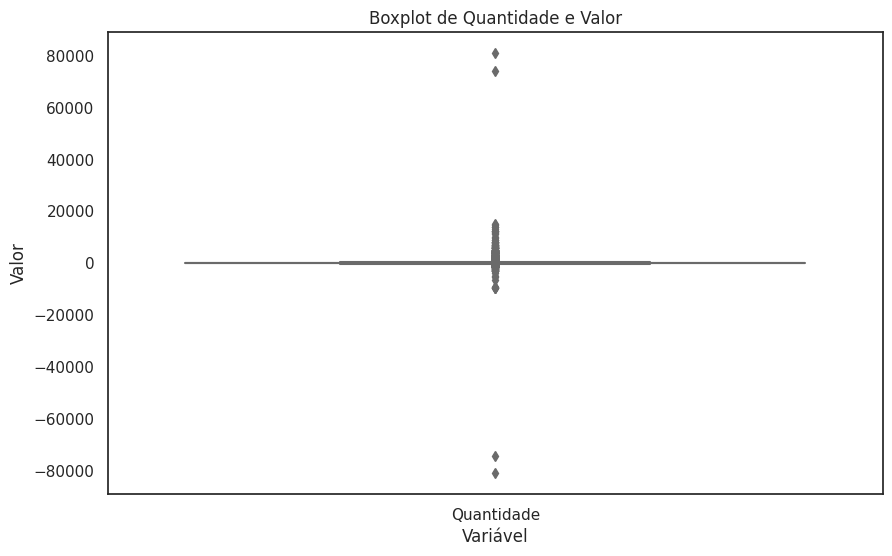

In [97]:
# Plotando boxplots para Quantidade e Valor
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_bronze[['Quantidade', 'Valor']])
plt.title('Boxplot de Quantidade e Valor')
plt.xlabel('Variável')
plt.ylabel('Valor')
plt.show()

In [98]:
# Calcular quartis
Q1 = df_bronze['Quantidade'].quantile(0.25)
Q3 = df_bronze['Quantidade'].quantile(0.75)

# Calcular intervalo interquartil (IQR)
IQR = Q3 - Q1

# Calcular limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers_quantidade = df_bronze[(df_silver['Quantidade'] < lower_bound) | (df_bronze['Quantidade'] > upper_bound)]


In [99]:
print("Outliers na variável Quantidade:")
print(outliers_quantidade)

Outliers na variável Quantidade:
      N° da fatura       Data da fatura  ID Cliente            País  \
12          537823   12/8/2020 14:25:00         NaN  United Kingdom   
27          576083   11/14/2021 8:22:00     17404.0          Sweden   
67          577783  11/21/2021 16:20:00     18139.0  United Kingdom   
95          569695   10/5/2021 15:35:00     16843.0  United Kingdom   
143         547419   3/23/2021 10:27:00     15061.0  United Kingdom   
...            ...                  ...         ...             ...   
18516       571698  10/18/2021 14:50:00     13805.0  United Kingdom   
18538       552232    5/6/2021 15:54:00         NaN  United Kingdom   
18549       549316     4/8/2021 9:54:00     12705.0         Germany   
18560       539039  12/15/2020 15:00:00     13124.0  United Kingdom   
18564       581220    12/8/2021 9:39:00     13924.0  United Kingdom   

       Quantidade    Valor  
12           1484  6073,71  
27           1060  1238,48  
67           1644  2786,40 

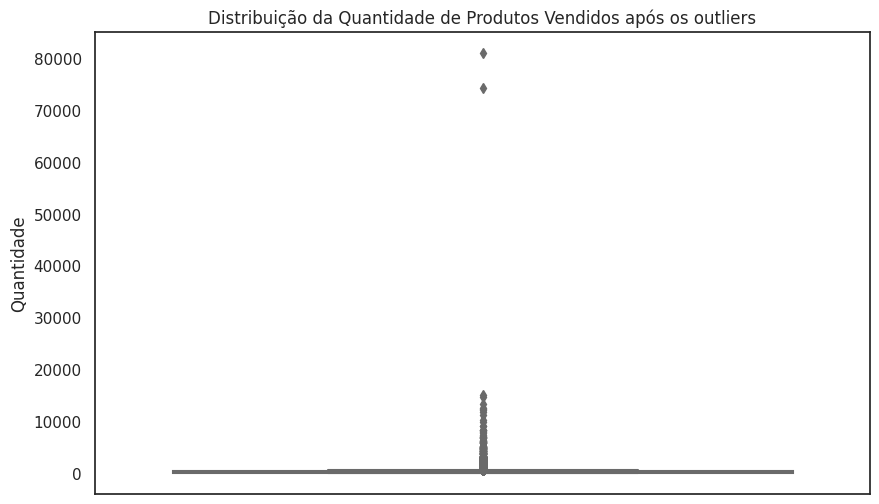

In [100]:
#  Distribuição da quantidade de produtos vendidos
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_silver, y='Quantidade')
plt.title('Distribuição da Quantidade de Produtos Vendidos após os outliers')
plt.ylabel('Quantidade')
plt.show()

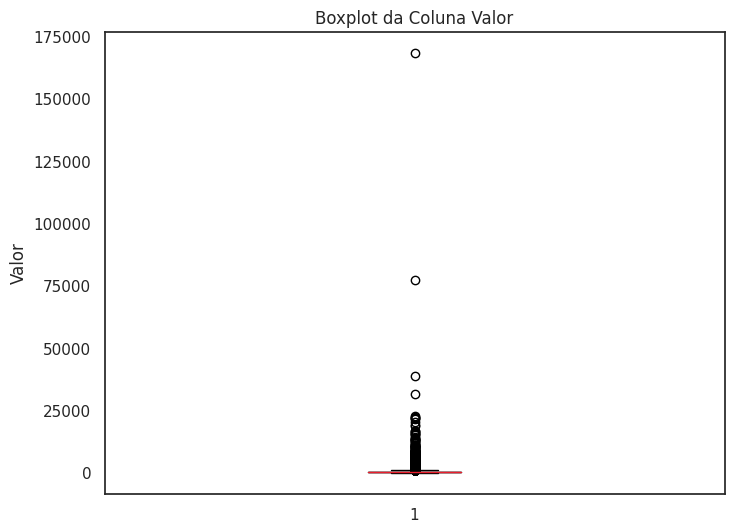

In [101]:
# Verificando outliers na coluna 'Valor'
plt.figure(figsize=(8, 6))
plt.boxplot(df_silver['Valor'])
plt.title('Boxplot da Coluna Valor')
plt.ylabel('Valor')
plt.show()

Os boxplots exibem uma linha de representação vertical contínua de dados, indicando que a maioria dos dados está concentrada em um intervalo muito pequeno. A presença de apenas dois outliers nos extremos sugere que a distribuição dos dados é altamente assimétrica, com a maioria dos valores agrupados em uma extremidade e alguns valores extremos muito distantes. Isso pode distorcer a escala da visualização, sendo necessário ajustar os eixos ou usar uma escala logarítmica para melhor visualização.

# Conclusão da Analise dos Outliers

Com base na análise de outliers e na remoção desses valores extremos, podemos concluir que os dados originais apresentavam uma distribuição altamente assimétrica, com a maioria dos valores concentrados em uma extremidade e poucos valores extremos distantes. A presença desses outliers pode distorcer as estatísticas descritivas e a compreensão geral dos dados.
Após a remoção dos outliers, observamos uma redução na dispersão dos dados e uma mudança na distribuição dos valores das faturas, com a concentração em valores menores. Isso sugere que as transações com valores extremamente altos foram eliminadas, resultando em uma distribuição mais homogênea e representativa dos dados restantes.

Portanto, a identificação e tratamento adequado dos outliers são essenciais para uma análise precisa e significativa dos dados, garantindo que as conclusões e insights derivados dessas análises sejam confiáveis e informativos.

Visualizando os dados antes da Camada Gold:

In [102]:
df_silver.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
6678,536365,2020-12-01 08:26:00,17850.0,United Kingdom,40,139.0
13085,536366,2020-12-01 08:28:00,17850.0,United Kingdom,12,22.0
8014,536368,2020-12-01 08:34:00,13047.0,United Kingdom,15,70.0
4904,536367,2020-12-01 08:34:00,13047.0,United Kingdom,83,278.0
5850,536369,2020-12-01 08:35:00,13047.0,United Kingdom,3,17.0
354,536370,2020-12-01 08:45:00,12583.0,France,449,855.0
9288,536371,2020-12-01 09:00:00,13748.0,United Kingdom,80,204.0
1982,536372,2020-12-01 09:01:00,17850.0,United Kingdom,12,22.0
14641,536373,2020-12-01 09:02:00,17850.0,United Kingdom,88,259.0
17621,536374,2020-12-01 09:09:00,15100.0,United Kingdom,32,350.0


In [103]:
df_silver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18554 entries, 6678 to 1725
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   N° da fatura    18554 non-null  object        
 1   Data da fatura  18554 non-null  datetime64[ns]
 2   ID Cliente      18554 non-null  float64       
 3   País            18554 non-null  object        
 4   Quantidade      18554 non-null  int64         
 5   Valor           18554 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.5+ MB


<a id='importar-dataset'></a>
## <font color="#FFDEBB"> Camanda GOLD: Análise dos dados | BUSSINES LEVEL AGGREGATE </font>

<a id='analise-metricas'></a>
# <font color="#FFDEBB"> BUSSINES LEVEL AGGREGATE </font>

<div class="alert alert-warning" > 
<strong><div style="color: rgb(234, 29, 44);"> Questões que nos propusemos a responder: :</div></strong> <br>
    <div style="color: rgb(234, 29, 44);">→ Quais países eles atendem? </div>
    <div style="color: rgb(234, 29, 44);">→ Quantos clientes eles possuem? </div>
    <div style="color: rgb(234, 29, 44);">→ Quanto fatura em média (valor) por mês? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual o mês que mais venderam (n° de faturas)? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual o mês que mais venderam (quantidade)? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual a média de venda (quantidade) e faturamento (valor) por país? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual a média de venda (quantidade) e gasto (valor) por cliente? </div>
    <div style="color: rgb(234, 29, 44);">→ Quantos clientes possuem mais de uma compra? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual foi o cliente com maior volume de compras? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual foi o cliente com maior gasto financeiro? </div>
    <div style="color: rgb(234, 29, 44);">→ Clientes que realizaram apenas uma compra por mês </div>


</div>

<div class="alert" > 
<strong><div style="color: rgb(255, 222, 187);"> Gráficos a serem construidos: :</div></strong> <br>
    <div style="color: rgb(255, 222, 187);">→ Gráfico - Quantidade de compras de cada país no ano </div>
    <div style="color: rgb(255, 222, 187);">→ Gráfico - Quantidade de compras de cada país no mês </div>
    <div style="color: rgb(255, 222, 187);">→ Gráfico - Faturamento de compras de cada país no ano </div>
    <div style="color: rgb(255, 222, 187);">→ Gráfico - Faturamento de compras de cada país no mês </div>
    <div style="color: rgb(255, 222, 187);">→ Existe algum horário do dia em que há maior volume de compras? </div>

</div>

In [104]:
# Realizando cópia do df_silver
df_gold = df_silver.copy()
print(f'O dataset possui {df_gold.shape[0]} registros a serem trabalhados.')

O dataset possui 18554 registros a serem trabalhados.


In [105]:
# Visualizar estatísticas descritivas
df_gold.describe().T

,count,mean,min,25%,50%,75%,max,std
Data da fatura,18554,2021-07-01 15:02:15.625741056,2020-12-01 08:26:00,2021-03-30 14:11:45,2021-07-12 14:52:30,2021-10-12 13:26:00,2021-12-09 12:50:00,NaN
ID Cliente,18554.0,15266.178668,12346.0,13777.0,15176.5,16779.0,18287.0,1733.940773
Quantidade,18554.0,278.568018,1.0,74.0,155.0,291.0,80995.0,972.030003
Valor,18554.0,479.823758,1.0,157.0,302.0,471.0,168469.0,1677.104074


### <font color="#FFB761"> 1 - Quais países eles atendem? </font>

In [106]:
# Carregando os dados mundiais
mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Países do mundo que estão presentes no Dataset
countries_to_plot = mundo[mundo['name'].isin(df_gold['País'].unique())]
countries_to_plot = countries_to_plot.sort_values(by='name')

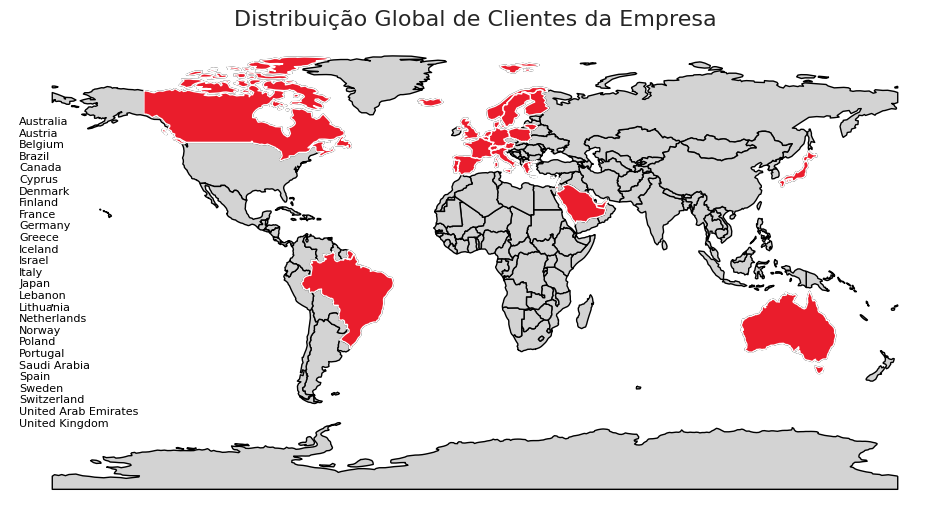

In [107]:
# Criando mapa
fig, ax = plt.subplots(figsize=(12, 8))
mundo.plot(ax=ax, color='lightgrey', edgecolor='black')
countries_to_plot.plot(ax=ax, color='#EA1D2C')

# Títulos  e legenda
ax.set_title('Distribuição Global de Clientes da Empresa', fontsize=16)
ax.set_xlabel('Comprimento', fontsize=12)
ax.set_ylabel('Altura', fontsize=12)
plt.axis('off')

# Legenda personalizada com os nomes dos países
legend_text = '\n'.join(countries_to_plot['name'])
legend = ax.text(0.01, 0.5, legend_text, fontsize=8, ha='left', va='center', color='black', transform=ax.transAxes)

Quantos países eles atendem?

In [108]:
print(f"A empresa atende {len(df_gold['País'].unique())} países.")

A empresa atende 37 países.


### <font color="#FFB761"> 2 - Quantos clientes eles possuem? </font>

In [109]:
num_clientes = len(df_gold['ID Cliente'].unique())
print(f"A empresa possui {num_clientes} clientes em todo o mundo.")

A empresa possui 4338 clientes em todo o mundo.


### <font color="#FFB761"> 3 - Quanto fatura em média (valor) por mês? </font>

A moeda utilizada pelo cliente é libras esterlinas.

In [110]:
faturamento_medio = sum(df_gold['Valor']/num_clientes)
print(f'O faturamento médio por mês da empresa é de {round(faturamento_medio, 2)} libras esterlinas.')

O faturamento médio por mês da empresa é de 2052.25 libras esterlinas.


### <font color="#FFB761"> 4 - Qual o mês que mais venderam (n° de faturas)? </font>

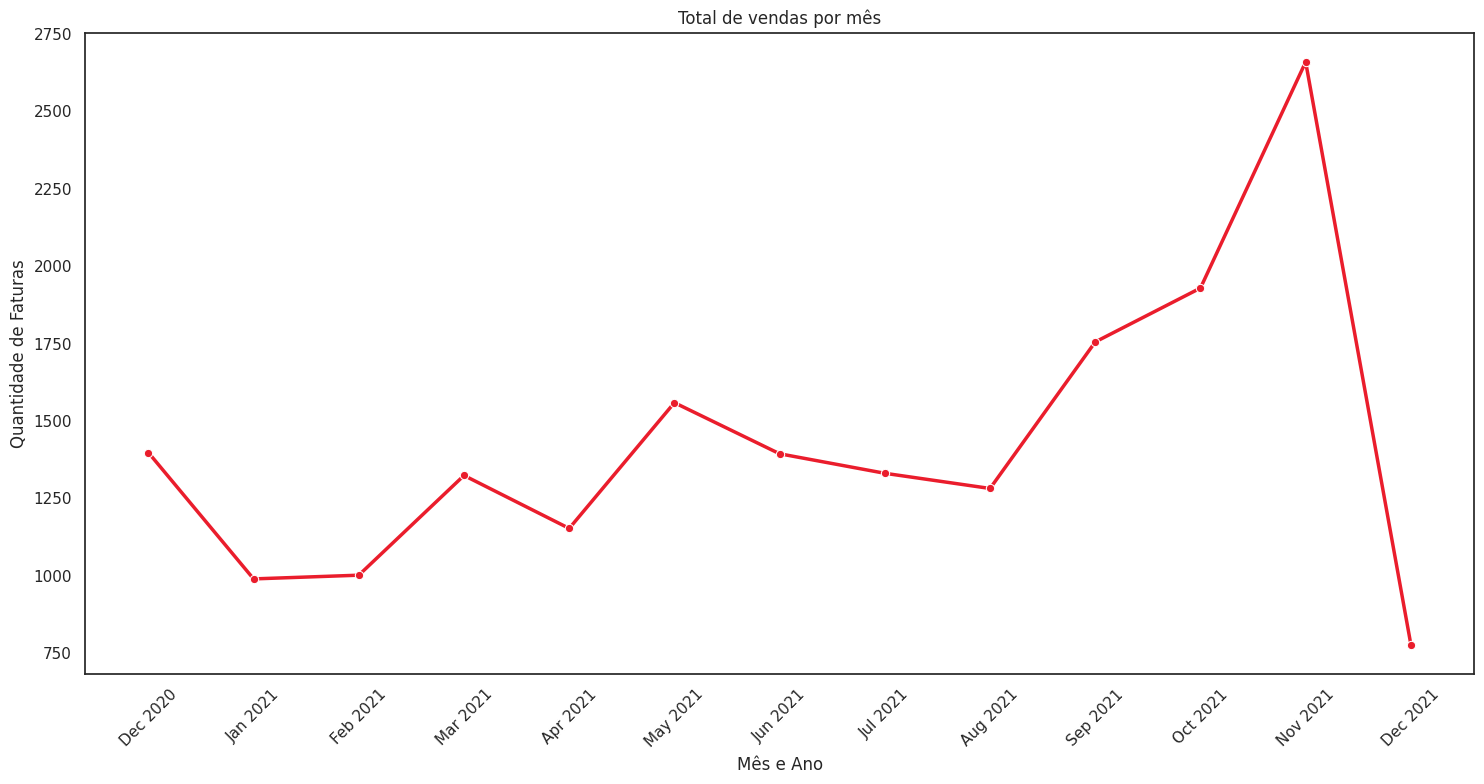

In [111]:
# Total de faturas por mês e ano
df_fatura_mes = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                             ['N° da fatura'].count()).reset_index()
df_fatura_mes.rename(columns={"N° da fatura": "Quantidade_de_faturas"},
                     inplace=True)

df_fatura_mes['Data da fatura'] = pd.to_datetime(df_fatura_mes['Data da fatura'])

# Extraindo o mês e o ano da coluna "Data da fatura"
df_fatura_mes['Mês'] = df_fatura_mes['Data da fatura'].dt.month
df_fatura_mes['Ano'] = df_fatura_mes['Data da fatura'].dt.year

# Criando uma coluna para mês e ano para o eixo x
df_fatura_mes['Mês_Ano'] = df_fatura_mes['Data da fatura'].dt.strftime('%b %Y')

sns.set_theme(style="white", palette=None)
plt.figure(figsize=(15, 8))

ax = sns.lineplot(data=df_fatura_mes,
                  x="Mês_Ano",
                  y="Quantidade_de_faturas",
                  color='#EA1D2C',
                  linewidth=2.5,
                  marker="o")
ax.set_xlabel('Mês e Ano')
ax.set_ylabel('Quantidade de Faturas')
ax.set_title('Total de vendas por mês')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [112]:
print(f"Data da última venda no mês de Dezembro de 2021: {df_gold['Data da fatura'].iloc[-1]}")

Data da última venda no mês de Dezembro de 2021: 2021-12-09 12:50:00


Como pode ser observado no gráfico, o mês que apresentou maior número de vendas foi em **novembro de 2021**, o que contrasta com a enorme queda de Dezembro, mês em que ocorre o Natal. Porém, ainda estamos vendo os dados muito por cima. Vamos visualizar mais de perto e ver se isso condiz com o esperado para o mês de dezembro até a data do último registro.

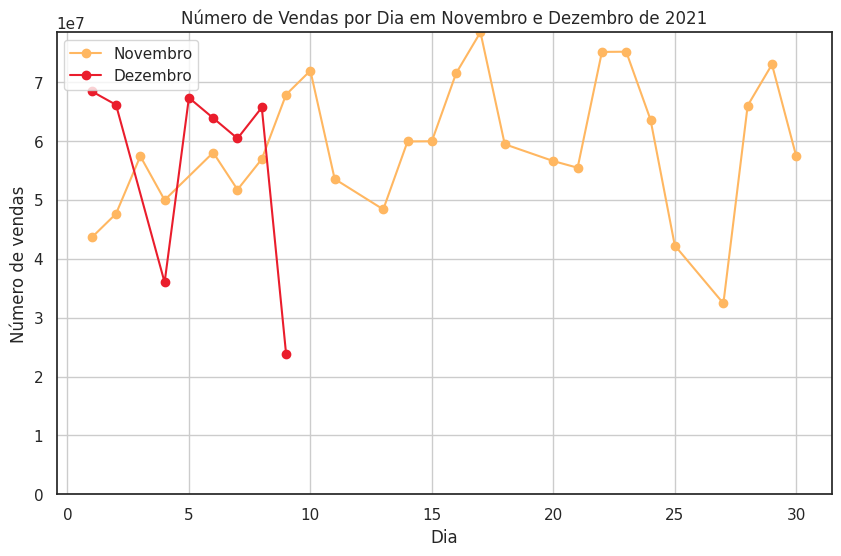

In [113]:
# Filtrando os dados para os meses de novembro e dezembro de 2021
df_filtered = df_gold[(df_gold['Data da fatura'] >= '2021-11-01') & (df_gold['Data da fatura'] <= '2021-12-31')]

# Extraindo dia e mês da coluna 'Data da fatura'
df_filtered['Dia'] = df_filtered['Data da fatura'].dt.day
df_filtered['Mês'] = df_filtered['Data da fatura'].dt.month

# Convertendo a coluna 'N° da fatura' para o tipo de dado numérico
df_filtered['N° da fatura'] = pd.to_numeric(df_filtered['N° da fatura'])

# Agrupando por dia a quantidade vendida
df_daily = df_filtered.groupby(['Mês', 'Dia'])['N° da fatura'].sum().reset_index()

# Encontrando o máximo de faturas vendidas por dia
max_faturas = df_daily['N° da fatura'].max()
plt.figure(figsize=(10, 6))

# Vendas em novembro
plt.plot(df_daily[df_daily['Mês'] == 11]['Dia'], df_daily[df_daily['Mês'] == 11]['N° da fatura'], marker='o', linestyle='-', label='Novembro')

# Vendas em dezembro
plt.plot(df_daily[df_daily['Mês'] == 12]['Dia'], df_daily[df_daily['Mês'] == 12]['N° da fatura'], marker='o', linestyle='-', label='Dezembro')

plt.xlabel('Dia')
plt.ylabel('Número de vendas')
plt.title('Número de Vendas por Dia em Novembro e Dezembro de 2021')
plt.legend()
plt.grid(True)

# Definindo o limite do eixo y como o máximo de faturas vendidas por dia
plt.ylim(0, max_faturas + 10)  # Adicionando uma margem de 10 para melhor visualização
plt.show()

Em relação ao mês de novembro, aos primeiros 09 dias do mês, dezembro apresenta um resultado melhor que novembro. Visto que durante esse período de tempo, o mês apresentou resultado inferior ao mês anterior apenas em um dia e meio (a coleta dos dados do dia 09 só possuem registro até o meio dia). Com base nisso, é possível afirmar que talvez o mês apresente resultado total superior ao mês onze.

### <font color="#FFB761"> 5 - Qual o mês que mais venderam (quantidade)? </font>

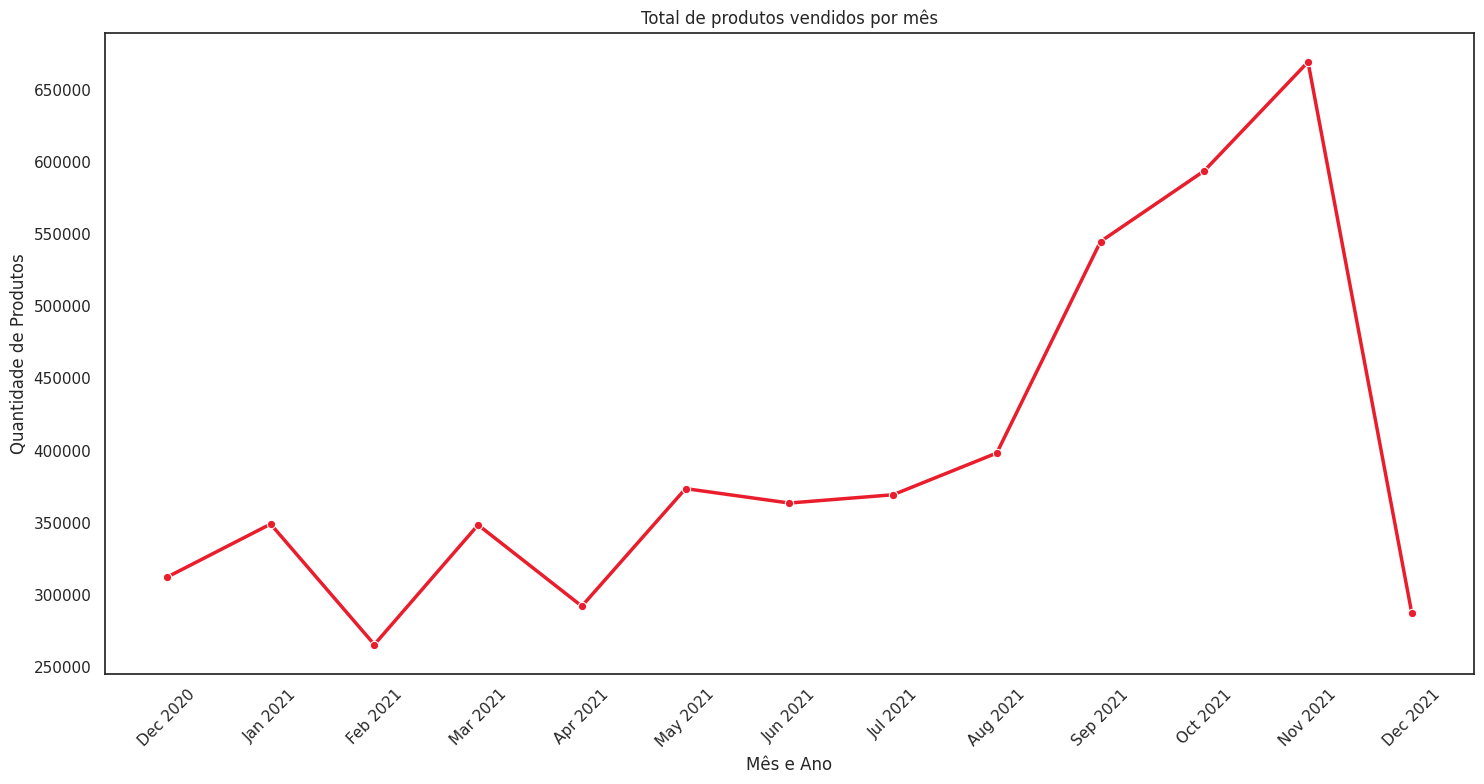

In [114]:
# Total de produtos por mês e ano
df_quant_mes = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                             ['Quantidade'].sum()).reset_index()
df_quant_mes.rename(columns={"Quantidade": "Quantidade_de_produtos"},
                     inplace=True)

df_quant_mes['Data da fatura'] = pd.to_datetime(df_fatura_mes['Data da fatura'])

# Extraindo o mês e o ano da coluna "Data da fatura"
df_quant_mes['Mês'] = df_quant_mes['Data da fatura'].dt.month
df_quant_mes['Ano'] = df_quant_mes['Data da fatura'].dt.year

# Criando uma coluna para mês e ano para o eixo x
df_quant_mes['Mês_Ano'] = df_quant_mes['Data da fatura'].dt.strftime('%b %Y')

sns.set_theme(style="white", palette=None)
plt.figure(figsize=(15, 8))

ax = sns.lineplot(data=df_quant_mes,
                  x="Mês_Ano",
                  y="Quantidade_de_produtos",
                  color='#EA1D2C',
                  linewidth=2.5,
                  marker="o")
ax.set_xlabel('Mês e Ano')
ax.set_ylabel('Quantidade de Produtos')
ax.set_title('Total de produtos vendidos por mês')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

Assim como a quantidade de vendas, a quantidade de produtos vendidos também é maior em novembro.

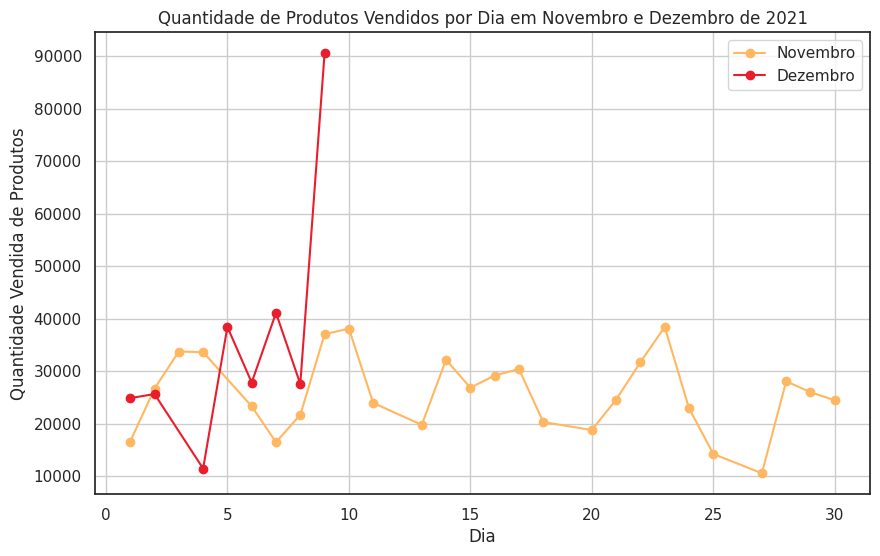

In [115]:
# Filtrando os dados para os meses de novembro e dezembro de 2021
df_filtered = df_gold[(df_gold['Data da fatura'] >= '2021-11-01') & (df_gold['Data da fatura'] <= '2021-12-31')]

# Extraindo dia, mês e ano da coluna 'Data da fatura'
df_filtered['Dia'] = df_filtered['Data da fatura'].dt.day
df_filtered['Mês'] = df_filtered['Data da fatura'].dt.month

# Agrupando por dia a quantidade vendida
df_daily = df_filtered.groupby(['Mês', 'Dia'])['Quantidade'].sum().reset_index()
plt.figure(figsize=(10, 6))

# Vendas em novembro
plt.plot(df_daily[df_daily['Mês'] == 11]['Dia'], df_daily[df_daily['Mês'] == 11]['Quantidade'], marker='o', linestyle='-', label='Novembro')

# Vendas em dezembro
plt.plot(df_daily[df_daily['Mês'] == 12]['Dia'], df_daily[df_daily['Mês'] == 12]['Quantidade'], marker='o', linestyle='-', label='Dezembro')

plt.xlabel('Dia')
plt.ylabel('Quantidade Vendida de Produtos')
plt.title('Quantidade de Produtos Vendidos por Dia em Novembro e Dezembro de 2021')
plt.legend()
plt.grid(True)
plt.show()

Apesar de vendo o geral o mês de dezembro parecer ruim, quando observado mais de perto é possível notar que ainda pode ser um mês muito promissor. E acabar sendo o mês com maior número de vendas ao longo não somente do ano, mas também de toda a história da empresa, que apresenta 1 ano e um mês de existência de acordo com os dados.

O mês de novembro pode estar indicando apenas o início de um final de ano muito positivo.

É válido lembrar que os dados nos informam as vendas até meio dia do dia 09. A não ser que seja um dia de trabalho meio período, é possível que a quantidade de produtos vendidos seja ainda maior.

### <font color="#FFB761"> 6 - Qual a média de venda (quantidade) e faturamento (valor) por país? </font>

In [116]:
# Calculando a média de venda por país
media_prod = df_gold['Quantidade'].sum()//len(df_gold['País'].unique())
print(f'A média de produtos vendidos por país é de {media_prod} unidades.')

A média de produtos vendidos por país é de 139690 unidades.


In [117]:
# Calculando a média de faturamento por país
media_fat = df_gold['Valor'].sum()//len(df_gold['País'].unique())
print(f'A média de faturamento por país é de {media_fat} libras esterlinas.')

A média de faturamento por país é de 240612.0 libras esterlinas.


### <font color="#FFB761"> 7 - Qual a média de venda (quantidade) e faturamento (valor) por cliente? </font>

In [118]:
# Calculando a média de venda por cliente
media_prod = df_gold['Quantidade'].sum()//len(df_gold['ID Cliente'].unique())
print(f'A média de produtos vendidos por cliente é de {media_prod} unidades.')

A média de produtos vendidos por cliente é de 1191 unidades.


In [119]:
# Calculando a média de faturamento por cliente
media_fat = df_gold['Valor'].sum()//len(df_gold['ID Cliente'].unique())
print(f'A média de faturamento por cliente é de {media_fat} libras esterlinas.')

A média de faturamento por cliente é de 2052.0 libras esterlinas.


### <font color="#FFB761"> 8 - Quantos clientes possuem mais de uma compra? </font>

In [120]:
# Identificando quantos clientes realizaram pelo menos duas compras
cli_recorr = df_gold['ID Cliente'].count() - df_gold['ID Cliente'].nunique()
cli_unicos = df_gold['ID Cliente'].nunique()

In [121]:
print(f'A empresa possui {cli_unicos} clientes que realizaram uma compra e {cli_recorr} clientes que fizeram mais de uma compra.')

A empresa possui 4338 clientes que realizaram uma compra e 14216 clientes que fizeram mais de uma compra.


### <font color="#FFB761"> 9 - Qual foi o cliente com maior volume de compras? </font>

In [122]:
clientes_volume = df_gold.copy()
clientes_volume.sort_values(by=['Quantidade'], ascending=False, inplace=True)
clientes_volume.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
9437,581483,2021-12-09 09:15:00,16446.0,United Kingdom,80995,168469.0
10527,541431,2021-01-18 10:01:00,12346.0,United Kingdom,74215,77183.0
17557,556917,2021-06-15 13:37:00,12415.0,Australia,15049,22775.0
3926,563076,2021-08-11 16:12:00,14646.0,Netherlands,14730,19150.0
3262,572035,2021-10-20 12:03:00,14646.0,Netherlands,13392,20277.0
15261,567423,2021-09-20 11:05:00,17450.0,United Kingdom,12572,31698.0
12164,552883,2021-05-12 10:13:00,14646.0,Netherlands,12266,14415.0
11622,563614,2021-08-18 08:51:00,12415.0,Australia,12196,21880.0
13872,562439,2021-08-04 18:06:00,12931.0,United Kingdom,11848,18841.0
9718,548011,2021-03-29 11:14:00,14646.0,Netherlands,11116,15719.0


O cliente com maior volume de compras foi o 16446, que está localizado no Reino Unido.

### <font color="#FFB761"> 10 - Qual foi o cliente com maior gasto financeiro? </font>

In [123]:
clientes_fat = df_gold.copy()
clientes_fat.sort_values(by=['Valor'], ascending=False, inplace=True)
clientes_fat.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
9437,581483,2021-12-09 09:15:00,16446.0,United Kingdom,80995,168469.0
10527,541431,2021-01-18 10:01:00,12346.0,United Kingdom,74215,77183.0
16715,556444,2021-06-10 15:28:00,15098.0,United Kingdom,60,38970.0
15261,567423,2021-09-20 11:05:00,17450.0,United Kingdom,12572,31698.0
17557,556917,2021-06-15 13:37:00,12415.0,Australia,15049,22775.0
18511,572209,2021-10-21 12:08:00,18102.0,United Kingdom,1920,22206.0
473,567381,2021-09-20 10:12:00,17450.0,United Kingdom,6760,22104.0
11622,563614,2021-08-18 08:51:00,12415.0,Australia,12196,21880.0
14171,550461,2021-04-18 13:20:00,15749.0,United Kingdom,9014,21535.0
3262,572035,2021-10-20 12:03:00,14646.0,Netherlands,13392,20277.0


O cliente que ofereceu maior faturamento foi também o 16446.

### <font color="#FFB761"> 11 - Horário do dia com maior fluxo/n° de vendas </font>

In [124]:
# Extraindo a hora do dia da coluna 'Data da fatura'
df_gold['Hora'] = df_gold['Data da fatura'].dt.hour

# Agrupar por hora do dia e calculando a contagem única de faturas
faturas_por_hora = df_gold.groupby('Hora')['N° da fatura'].nunique()

# Qual a hora com maior volume de vendas?
hora_maior_volume = faturas_por_hora.idxmax()
maior_volume = faturas_por_hora.max()

print("Horário com o maior volume de compras:", hora_maior_volume)
print("Maior volume de compras:", maior_volume)

Horário com o maior volume de compras: 12
Maior volume de compras: 3129


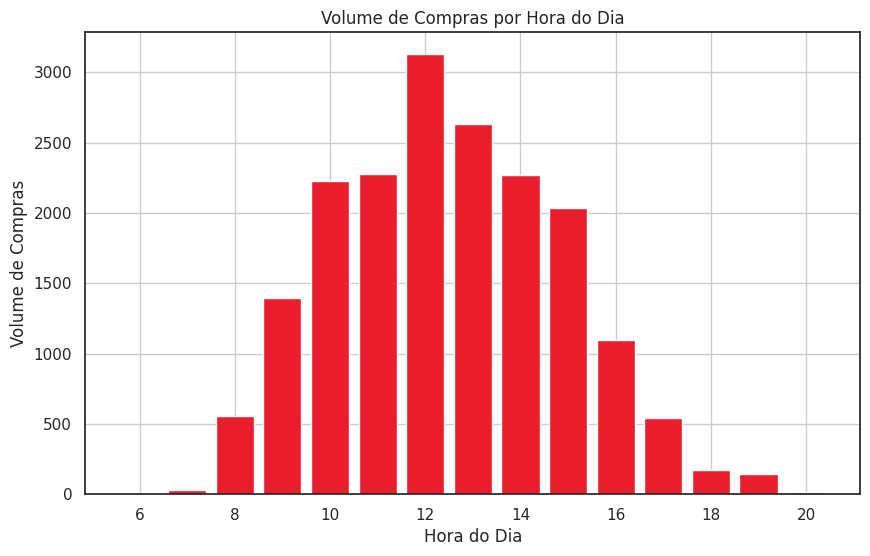

In [125]:
plt.figure(figsize=(10, 6))
plt.bar(faturas_por_hora.index, faturas_por_hora.values, color='#EA1D2C')
plt.xlabel('Hora do Dia')
plt.ylabel('Volume de Compras')
plt.title('Volume de Compras por Hora do Dia')
plt.grid(True)
plt.show()

Como pode ser observado, ao longo dos meses, o horário com maior volume de vendas é às 12h.

### <font color="#FFB761"> 12 - Clientes que realizaram apenas uma compra por mês </font>

Dentro de cada grupo de Mês e Ano, é feita uma contagem de clientes únicos. Ou seja, realizaram apenas uma compra.

In [126]:
# Número de clientes únicos por mês e ano
df_clientes_mes_ano = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                                   ['ID Cliente'].nunique()).reset_index()
df_clientes_mes_ano.rename(columns={"ID Cliente": "Número de clientes únicos"},
                            inplace=True)

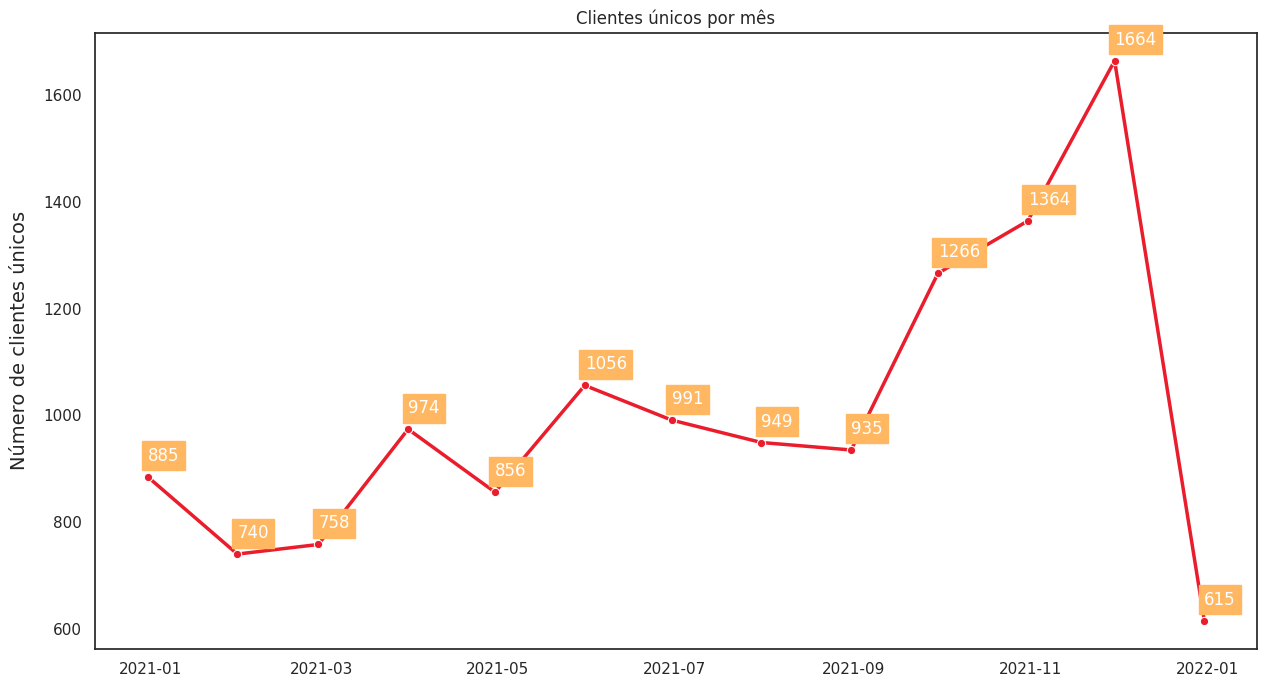

In [127]:
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))

ax = sns.lineplot(data=df_clientes_mes_ano,
                  x="Data da fatura",
                  y="Número de clientes únicos",
                  color='#EA1D2C',
                  linewidth=2.5,
                  marker="o")

ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Número de clientes únicos', fontsize=14, labelpad=10)
ax.set_title('Clientes únicos por mês')

# incluindo rótulos nos pontos do gráfico
for x, y in zip(df_clientes_mes_ano['Data da fatura'], 
                df_clientes_mes_ano['Número de clientes únicos']):
     plt.text(x = x, 
               y = y+30, 
               s = '{:.0f}'.format(y), 
               color = 'white').set_backgroundcolor('#FFB761') 


O mês de Novembro/2021 teve o maior pico de clientes únicos realizando compras. É possível que isso ocorreu por causa de eventos que estimulam as compras como, Black Friday.

### <font color="#EA1D2C"> Montante total de vendas por mês </font>

In [128]:
# realizando o cálculo total de vendas por mês
df_montante_mes = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                               ['Valor'].sum()).reset_index()
df_montante_mes.columns = ['Data da fatura', 'Montante Total de Vendas']

Text(0, 0.5, 'Valor em Libras (k)')

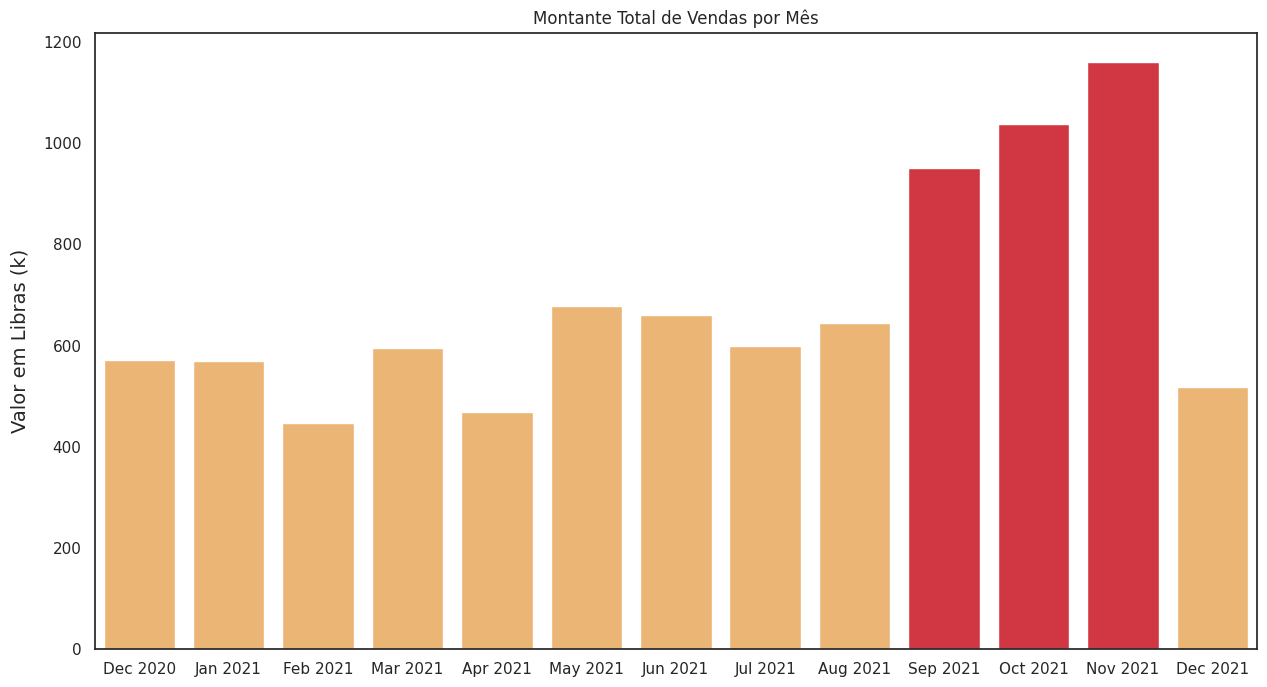

In [129]:
# transformando o valor em múltiplo de 1.000 ou K.
df_montante_mes['Montante Total de Vendas (K)'] = (df_montante_mes['Montante Total de Vendas']
                                                   /1000).round(2)

# convertendo tipo do dado da coluna "Ano_mes" para string
df_montante_mes['Data da fatura'] = df_montante_mes['Data da fatura'].dt.strftime('%b %Y')

# selecionando o valor mínimo dos 3 maiores Montantes totais de vendas
minimo = min(df_montante_mes['Montante Total de Vendas (K)'].nlargest(n=3))

clrs = ['#FFB761' if (x < minimo) else '#EA1D2C' 
        for x in df_montante_mes['Montante Total de Vendas (K)']]

# criando o gráfico de barras
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))
ax = sns.barplot(x="Data da fatura",
                 y="Montante Total de Vendas (K)",
                 data=df_montante_mes,
                 ci=False,
                 palette=clrs)

ax.set_title('Montante Total de Vendas por Mês')
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Valor em Libras (k)', fontsize=14, labelpad=10)

### <font color="#EA1D2C"> Montante de vendas dentro e fora do Reino Unido, por mês </font>

In [130]:
# Criando coluna para classificar se o cliente pertence ou não ao Reino Unido
df_gold.loc[df_gold['País']=="United Kingdom", 'Pertence UK'] = "SIM"
df_gold.loc[df_gold['País']!="United Kingdom", 'Pertence UK'] = "NÃO"

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Dec 2020'),
  Text(1, 0, 'Jan 2021'),
  Text(2, 0, 'Feb 2021'),
  Text(3, 0, 'Mar 2021'),
  Text(4, 0, 'Apr 2021'),
  Text(5, 0, 'May 2021'),
  Text(6, 0, 'Jun 2021'),
  Text(7, 0, 'Jul 2021'),
  Text(8, 0, 'Aug 2021'),
  Text(9, 0, 'Sep 2021'),
  Text(10, 0, 'Oct 2021'),
  Text(11, 0, 'Nov 2021'),
  Text(12, 0, 'Dec 2021')])

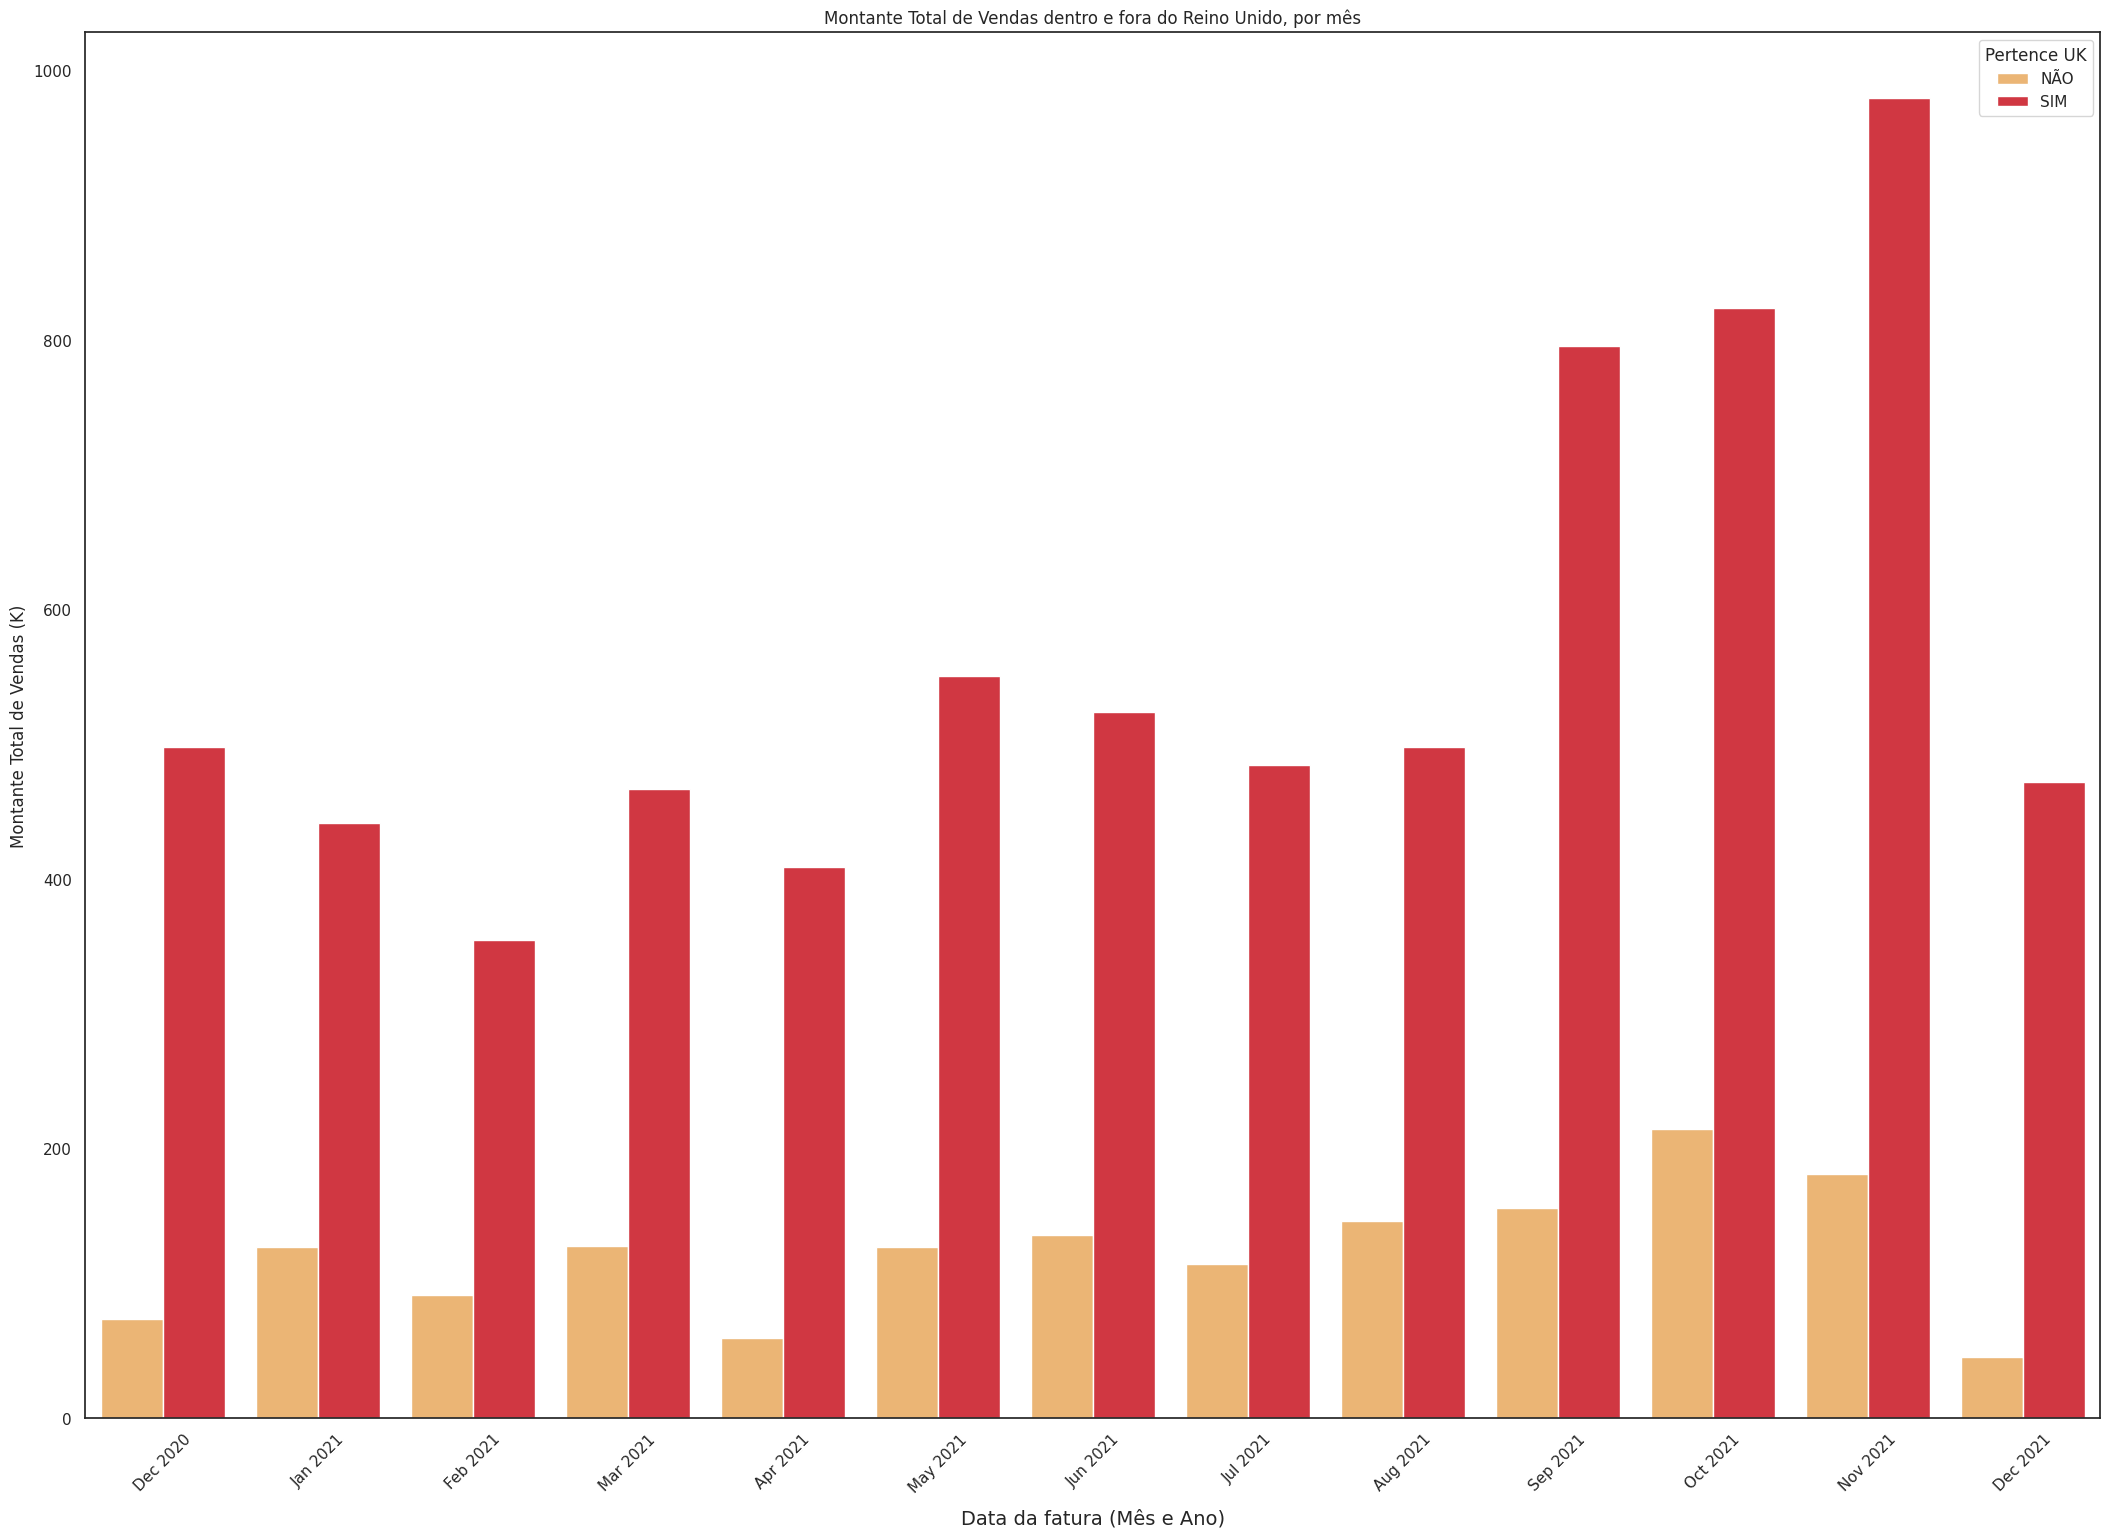

In [131]:
df_mes = pd.DataFrame(df_gold.groupby([pd.Grouper(key='Data da fatura', freq='M'), 'Pertence UK'])
                               ['Valor'].sum()).reset_index()
df_mes.columns = ['Data da fatura','Pertence UK','Montante Total de Vendas']
df_mes['Montante Total de Vendas (K)'] = (df_mes['Montante Total de Vendas']/1000).round(2)

sns.set_theme(style="white", palette=['#FFB761', "#EA1D2C"])
plt.figure(figsize = (26,18))
ax = sns.barplot(x=df_mes['Data da fatura'].dt.strftime('%b %Y'), 
                 y="Montante Total de Vendas (K)",
                 data=df_mes,
                 hue='Pertence UK',
                 ci=False)

ax.set_title('Montante Total de Vendas dentro e fora do Reino Unido, por mês')
ax.set_xlabel('Data da fatura (Mês e Ano)', fontsize=14, labelpad=10)

plt.xticks(rotation=45)

Analise com todos os dados

In [132]:
# Estatísticas descritivas
desc_stats = df_gold.describe()
print(desc_stats)

                      Data da fatura    ID Cliente    Quantidade  \
count                          18554  18554.000000  18554.000000   
mean   2021-07-01 15:02:15.625741056  15266.178668    278.568018   
min              2020-12-01 08:26:00  12346.000000      1.000000   
25%              2021-03-30 14:11:45  13777.000000     74.000000   
50%              2021-07-12 14:52:30  15176.500000    155.000000   
75%              2021-10-12 13:26:00  16779.000000    291.000000   
max              2021-12-09 12:50:00  18287.000000  80995.000000   
std                              NaN   1733.940773    972.030003   

               Valor          Hora  
count   18554.000000  18554.000000  
mean      479.823758     12.503234  
min         1.000000      6.000000  
25%       157.000000     11.000000  
50%       302.000000     12.000000  
75%       471.000000     14.000000  
max    168469.000000     20.000000  
std      1677.104074      2.372159  


In [134]:
# Amostragem Aleatória
df_sample = df_gold.sample(n=1000, random_state=42)
# Estatísticas Descritivas da Amostra
desc_stats_sample = df_sample.describe()
print(desc_stats_sample)

                   Data da fatura    ID Cliente   Quantidade        Valor  \
count                        1000   1000.000000  1000.000000   1000.00000   
mean   2021-07-03 23:32:12.300000  15233.565000   272.320000    452.85600   
min           2020-12-01 12:36:00  12352.000000     1.000000      1.00000   
25%           2021-04-04 12:15:15  13708.000000    77.750000    161.00000   
50%           2021-07-14 10:20:30  15129.500000   162.000000    306.00000   
75%           2021-10-12 15:09:30  16745.000000   294.250000    464.00000   
max           2021-12-09 12:49:00  18272.000000  8174.000000  11956.00000   
std                           NaN   1733.917135   515.884094    797.17235   

              Hora  
count  1000.000000  
mean     12.528000  
min       7.000000  
25%      11.000000  
50%      12.000000  
75%      14.000000  
max      20.000000  
std       2.286579  


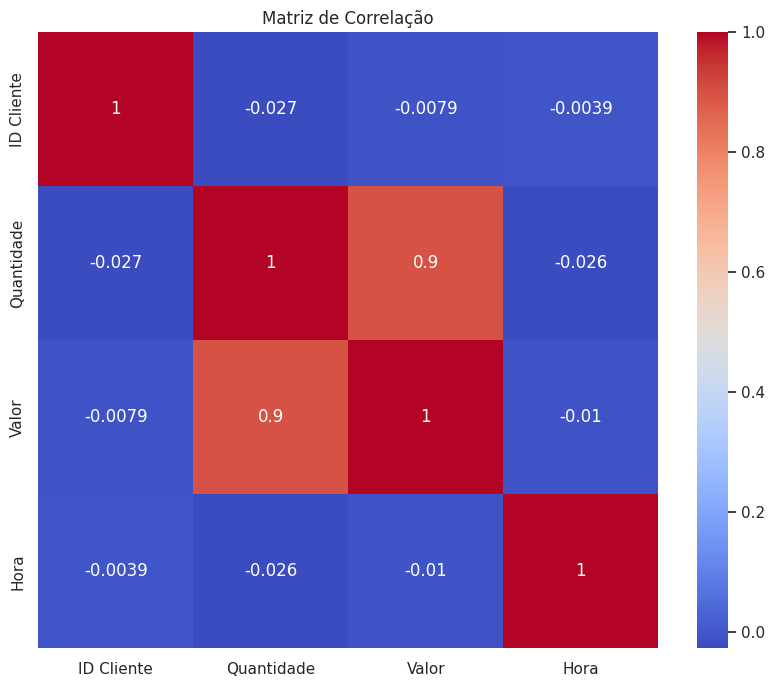

In [140]:
# Matriz de Correlação da Amostra
numeric_columns = df_sample.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

O cliente que ofereceu o maior faturamento foi o cliente com o ID 16446.

O horário do dia com o maior fluxo/número de vendas é às 12h. Isso sugere que esse horário é o mais movimentado em termos de transações comerciais.

As estatísticas descritivas do dataframe completo mostram que a média de quantidade vendida é de aproximadamente 278 unidades, com um desvio padrão alto de aproximadamente 972 unidades. Isso indica uma grande variabilidade nos dados de quantidade vendida. O mesmo padrão é observado para o valor das transações, com uma média de cerca de 479 e um desvio padrão de aproximadamente 1677, o que também sugere uma ampla dispersão nos valores das transações.

Ao realizar uma amostragem aleatória do dataframe, observamos que as estatísticas descritivas da amostra são semelhantes às do dataframe completo, o que sugere que a amostra é representativa da população total.

A matriz de correlação da amostra não revela fortes correlações entre as variáveis. Isso sugere que as variáveis estudadas (ID do cliente, quantidade, valor e hora) têm um relacionamento fraco entre si.

Em resumo, o cliente com o ID 16446 foi responsável pelo maior faturamento, o horário com o maior volume de vendas foi às 12h e os dados de quantidade e valor das transações mostram uma grande variabilidade.